In [112]:
from langchain_groq import ChatGroq
from CONFIG import GROQ_MODEL, OPENAI_EMBEDDED_MODEL
from langchain_openai import OpenAIEmbeddings
from pydantic import BaseModel, StrictBool, Field
from typing import List, TypedDict, Literal
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from dotenv import load_dotenv
from langchain_community.vectorstores import FAISS
from langgraph.graph import START, END, StateGraph
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

In [113]:
load_dotenv()
llm = ChatGroq(model=GROQ_MODEL)
embedded_model = OpenAIEmbeddings(model=OPENAI_EMBEDDED_MODEL)

In [114]:
pdfs = (
    PyPDFLoader(file_path="A:\AI_Projects_Practice\Self-RAG\KaravanTech_Company_Policies.pdf").load() + 
    PyPDFLoader(file_path="A:\AI_Projects_Practice\Self-RAG\KaravanTech_Company_Profile.pdf").load() + 
    PyPDFLoader(file_path="A:\AI_Projects_Practice\Self-RAG\KaravanTech_Products_and_Pricing.pdf").load()
)

In [115]:
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=60).split_documents(pdfs)
vector_store = FAISS.from_documents(splitter, embedded_model)
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 4})

In [116]:
class STATE(TypedDict):
    question: str
    retrieve_or_not: bool

    docs: List[Document]
    relevece_docs: List[Document]
    
    answer: str

In [117]:
class should_retrive_or_not(BaseModel):
    retrieve_or_not: bool = Field(..., description="true if question needs document retrieval, false if answerable from general knowledge")

decision_prompt = ChatPromptTemplate.from_messages(
	[
	(
		"system",
		"You decide whether retrieval is needed.\n"
		"Return JSON that matches this schema:\n"
		"{{'retrieve_or_not': boolean}}\n\n"
		"Guidelines:\n"
		"- retrieve_or_not=True if answering requires specific facts, citations, or info likely not in the model.\n"
		"- retrieve_or_not=False for general explanations, definitions, or reasoning that doesn't need sources.\n"
		"- If unsure, choose True."
	),
	(
		"human",
		"user question is: {question}"
	)
	]
)

output = llm.with_structured_output(should_retrive_or_not)

def decision_node(state: 'STATE'):
	decision: should_retrive_or_not = output.invoke(decision_prompt.format_messages(question=state['question']))       
	return {'retrieve_or_not': decision.retrieve_or_not}

In [118]:
direct_generate_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer the question using only your general knowledge.\n"
            "Do NOT assume access to external documents.\n"
            "If you are unsure or the answer requires specific sources, say:\n"
            "I don't know based on my general knowledge. "
        ),
        ("human", "{question}")
    ]
)

def direct_generate(state: 'STATE'):
    answer = llm.invoke(direct_generate_prompt.format_messages(question=state['question']))
    return {"answer": answer.content}

In [119]:
def retriever_node(state: 'STATE'):
    return {'docs': retriever.invoke(state['question'])}

In [120]:
class relevence_docs(BaseModel):
    relevent_or_not: bool = Field(
        ...,
        description="True if the document help answer to the question else False."
    )

relevence_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "you are judging document relevence.\n"
            "Return JSON that matchs this schema:\n"
            "{{'relevent_or_not': boolean}}\n\n"
            "A document is relevent if it contains information useful for asnwering the question."
        ),
        (
            "human",
            "question:\n{question}\n\nDocument:\n{document}" 
        )
    ]
)

relevence_llm = llm.with_structured_output(relevence_docs)

def is_relevence(state: 'STATE'):
    relevent_docs: List[Document] = []
    for doc in state['docs']:
        decision: relevence_docs = relevence_llm.invoke(
            relevence_prompt.format_messages(
                question=state['question'],
                document=doc.page_content
            )
        )
        if decision.relevent_or_not:
            relevent_docs.append(doc)
    
    return {'relevece_docs': relevent_docs}

In [121]:
def router_node(state: STATE) -> Literal['direct_generate', 'retriever_node']:
    if state['retrieve_or_not']:
        return 'retriever_node'
    return 'direct_generate'

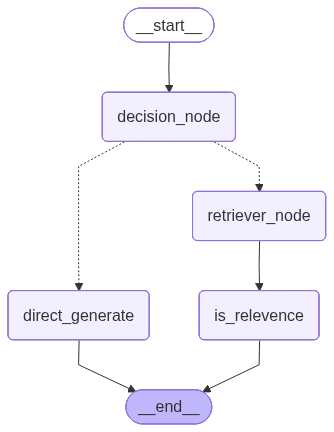

In [122]:
graph = StateGraph(STATE)

graph.add_node('decision_node', decision_node)
graph.add_node('retriever_node', retriever_node)
graph.add_node('direct_generate', direct_generate)
graph.add_node('is_relevence', is_relevence)

graph.add_edge(START, 'decision_node')
graph.add_conditional_edges(
    'decision_node',
    router_node,
    {
        'retriever_node': 'retriever_node',
        'direct_generate': 'direct_generate'
    }
)

graph.add_edge("retriever_node", "is_relevence")
graph.add_edge("is_relevence", END)
graph.add_edge("direct_generate", END)

gra = graph.compile()
gra

In [123]:
gra.invoke({'question': 'what about deep learnign'})

{'question': 'what about deep learnign',
 'retrieve_or_not': False,
 'answer': 'Deep learning is a subset of machine learning, which is a subset of artificial intelligence (AI). It involves the use of artificial neural networks to analyze and interpret data. These neural networks are designed to mimic the structure and function of the human brain, with layers of interconnected nodes (neurons) that process and transmit information.\n\nDeep learning algorithms are trained on large datasets, allowing them to learn and improve over time. They are particularly useful for tasks such as:\n\n1. Image recognition and classification\n2. Natural language processing (NLP) and speech recognition\n3. Predictive modeling and forecasting\n4. Autonomous vehicles and robotics\n\nSome key characteristics of deep learning include:\n\n1. **Multiple layers**: Deep learning models typically consist of multiple layers, each of which processes and transforms the input data in a different way.\n2. **Non-linear 

In [124]:
result = gra.invoke({'question': 'who is the CEO of karavantech'})

In [125]:
result

{'question': 'who is the CEO of karavantech',
 'retrieve_or_not': True,
 'docs': [Document(id='fb8a60ea-d9ee-404d-8fd0-bbca6dbae27f', metadata={'producer': 'ReportLab PDF Library - (opensource)', 'creator': '(unspecified)', 'creationdate': '2026-02-21T10:38:35+00:00', 'author': '(anonymous)', 'keywords': '', 'moddate': '2026-02-21T10:38:35+00:00', 'subject': '(unspecified)', 'title': '(anonymous)', 'trapped': '/False', 'source': 'A:\\AI_Projects_Practice\\Self-RAG\\KaravanTech_Company_Profile.pdf', 'total_pages': 2, 'page': 0, 'page_label': '1'}, page_content='KaravanTech Solutions\nCompany Profile\nCompany Overview\nKaravanTech Solutions Pvt. Ltd. is a Karachi-based technology company founded in 2019, specializing in\nsoftware development, cloud infrastructure, and digital transformation services for enterprises across\nPakistan and the broader South Asian region. With a growing team of over 120 professionals,\nKaravanTech partners with organizations in banking, retail, logistics, and

In [126]:
result['question']

'who is the CEO of karavantech'

In [ ]:
for i in result['docs']:
    print(i.page_content)
    print('=-'*60)

KaravanTech Solutions
Company Profile
Company Overview
KaravanTech Solutions Pvt. Ltd. is a Karachi-based technology company founded in 2019, specializing in
software development, cloud infrastructure, and digital transformation services for enterprises across
Pakistan and the broader South Asian region. With a growing team of over 120 professionals,
KaravanTech partners with organizations in banking, retail, logistics, and public sector to deliver scalable
and reliable technology solutions.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
 Security – We treat data protection as a fundamental responsibility, not an afterthought.
Founder & Leadership Team
KaravanTech was founded by Omar Farooq, an engineer with 15 years of experience across fintech and
enterprise software in Pakistan and the Middle East. The leadership team brings deep expertise in
software engineering, product strategy, and business operations.
 Omar Farooq – CEO & 

In [128]:
result['retrieve_or_not']

True

In [130]:
for i in result['relevece_docs']:
    print(i.page_content)

 Security – We treat data protection as a fundamental responsibility, not an afterthought.
Founder & Leadership Team
KaravanTech was founded by Omar Farooq, an engineer with 15 years of experience across fintech and
enterprise software in Pakistan and the Middle East. The leadership team brings deep expertise in
software engineering, product strategy, and business operations.
 Omar Farooq – CEO & Founder
 Zara Hussain – CTO – Cloud Architecture & DevOps
